<a href="https://colab.research.google.com/github/femtonelson/keras-gpu-multiclass-image-classification/blob/master/multiclass_image_classification_Scratch_vs_AlexNet_vs_DenseNet_vs_ResNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-class Image Classification : AlexNet vs ResNet vs DenseNet (PyTorch) vs Model from Scratch (Keras)**

Images of natural scenes around the world are provided in a zip file which contains : "seg_train' with 14000 images and "seg_test" with 3000 images. Each image is of size 150x150 pixels and each image in seg_train and seg_test is labelled with one of the 6 categories : {buildings, forest, glacier, mountain, sea, street}

The objective is to compare various models, one from scratch (in keras API) and three pretrained : AlexNet, ResNet, DenseNet models (in Pytorch) to choose the best model for classification. 

Data Source : https://www.kaggle.com/puneet6060/intel-image-classification/download

Environment : Google Colab & Drive

In [0]:
# Import necessary libraries
import cv2 # OpenCV package required
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
from PIL import Image

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [4]:
# Mount Google Drive storage containing images
from google.colab import drive
drive.mount('/content/drive')

image_dir = 'drive/My Drive/Colab Notebooks/input/'
!ls 'drive/My Drive/Colab Notebooks/input'

# Training, validation and testing folders
train_dir = 'seg_train'
test_dir = 'seg_test'
pred_dir = 'seg_pred'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
seg_pred  seg_test  seg_train


# **Model From Scratch - Keras (TensorFlow backend)**

## Read and Explore Dataset

In [0]:
def read_images(directory):
    """ Function to read images"""
    output_images = []
    output_labels = []
     
    # List the subfolders in the provided directory, each subfolder is a label
    for subfolder in os.listdir(directory):
        # Get label associated with subfolder
        label = get_label(subfolder)

        # List the images in current subfolder
        for img in os.listdir(directory+r'/'+subfolder):
            # Read image
            image = cv2.imread(directory+r'/'+subfolder+r'/'+img)

            # Resize image ==> All images should have the same width and height: 150 x 150 pixels, no change in number of channels
            image = cv2.resize(image, (150,150))
            output_images.append(image)
            output_labels.append(label)
            
    images = np.array(output_images)
    labels = np.array(output_labels)
    
    # Reshuffle the images to avoid biasing algorithms with the default order
    return shuffle(images, labels, random_state=50)

def get_label(subfolder):
    """"Function to map labels to numerical values"""
    labels = {'buildings':0, 'glacier':1, 'forest':2, 'mountain':3, 'sea':4, 'street':5}
    return labels[subfolder]

In [0]:
# Read train and test images into numpy arrays
train_images, input_train_labels = read_images(image_dir+train_dir)
test_images, input_test_labels = read_images(image_dir+test_dir)

# Perform one-hot encoding of labels to obtain an array with as many columns as classes and as many rows as images
train_labels = to_categorical(input_train_labels)
test_labels = to_categorical(input_test_labels)

In [195]:
# Shape of Images
print("The shape of train_images : {}, shape of train labels : {}".format(train_images.shape, train_labels.shape))
print("The shape of test_images : {}, shape of test labels : {}".format(test_images.shape, test_labels.shape))

The shape of train_images : (14033, 150, 150, 3), shape of train labels : (14033, 6)
The shape of test_images : (3000, 150, 150, 3), shape of test labels : (3000, 6)


All read images are square, with a width and height of 150 pixels and have 3 channels (R, G, B).

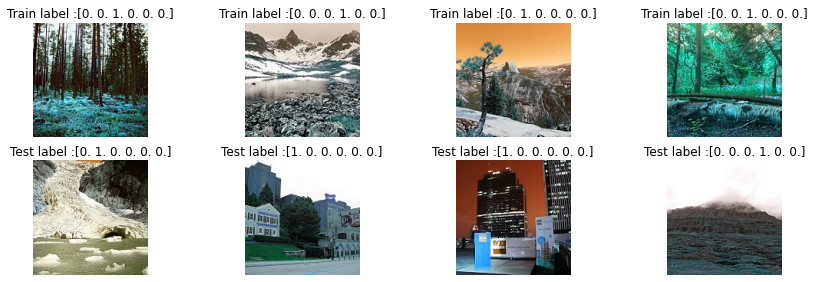

In [198]:
# Display the first 04 images of each data set
fig, ax = plt.subplots(2, 4)

# Leave some space above each subplot
fig.subplots_adjust(top=1, right=2)

for j in range(4):
    #1st row
    ax[0,j].imshow(train_images[j])
    ax[0,j].set_title('Train label :' + str(train_labels[j]))
    ax[0,j].axis('off')
    
    #2nd row
    ax[1,j].imshow(test_images[j])
    ax[1,j].set_title('Test label :'+str(test_labels[j]))
    ax[1,j].axis('off')


**buildings: 0 or [1 0 0 0 0 0],<br>glacier: 1 or [0 1 0 0 0 0],<br>forest: 2 or [0 0 1 0 0 0],<br>mountain: 3 or [0 0 0 1 0 0],<br>sea: 4 or [0 0 0 0 1 0],<br>street: 5 or [0 0 0 0 0 1]**

## Train a CNN model
A simple CNN model comprises :
- An input layer (an input image)
- At least one hidden convolutional layer (of class Conv2D()) : In this layer we need to specify the shape of input images,  the number of kernels to be used, the size of these kernels, an activation function. During the training of the CNN, the weights of the kernels are adjusted by the backpropagation algorithm. As compared to a fully connected layer of a simple neural network where each pixel of an image corresponds to a trainable weight/parameter (exple 150x150x3 = 67500), there are much fewer weights in a convolutional layer : the number of kernels (exple 10) * kernel size (exple 3x3) = 90.  
- A flatten layer (of class Flatten()) which converts images convolved by the kernels of the convolutional layer into a 1D array and 
- Finally a fully connected output layer (of class Dense()) which provides the output of the model.

However to extract more complex features from input images, it may be necessary to use additional convolutional layers(inspired by the human visual system) which may have different kernel counts and sizes or even padding types. The difficulty in such training therefore lies in the search for the model architecture which gives optimal results. In this process we may adjust hyperparameters like :
- The number of convolutional layers
- The number and size of kernels per convolutional layer
- The padding type to specify if convolved images of a layer should have the same size as the input image
- The activation function of each layer

Also we need to choose :
- An optimizer or backpropagation algorithm
- A loss function to be minimized by the optmizer

We may use :
- Pooling layers between subsequent convolutional layers to reduce significantly the number of parameters and train the model faster however at a cost

To avoid overfitting our CNN model we can apply regularization techniques like :
- Addition of Dropout layers, to randomly ignore some neurons/kernels during an epoch of training
- Early Stopping, to stop training when the validation error reaches a suitable level
- Batch Normalization, to rescale the outputs of a layer

In [199]:
def CNNModel(input_h, input_w, input_c, nb_classes):
  """ input_h, input_w, input_c : Input tensor shape
      nb_classes : Number of output classes """
  model = Sequential()
  model.add(Conv2D(115, kernel_size=3, activation='relu',input_shape=(input_h, input_w, input_c)))
  model.add(Conv2D(80, kernel_size=3, activation='relu'))
  model.add(MaxPool2D(4))
  model.add(Conv2D(100, kernel_size=3, activation='relu'))
  model.add(Conv2D(50, kernel_size=3, activation='relu'))
  model.add(Conv2D(30, kernel_size=3, activation='relu'))
  model.add(MaxPool2D(4))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(nb_classes, activation='softmax')) 
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# CNN Model from Scratch
model = CNNModel(150, 150, 3, 6)

# Display model architecture
model.summary()

# Fit the model
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 115)     3220      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 80)      82880     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 100)       72100     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 50)        45050     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 30)        13530     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 30)         

82.4% validation accuracy achieved in 9 epochs with the above model architecture, obtained after trying several numbers of hidden layers and kernels per layer.<br>

## Model Evaluation

Which image classes are well classified by the model and which are poorly classified? Using sklearn's classification report and confusion matrix, let's dig further.<br>
**buildings: 0 or [1 0 0 0 0 0]<br>
glacier: 1 or [0 1 0 0 0 0]<br>
forest: 2 or [0 0 1 0 0 0]<br>
mountain: 3 or [0 0 0 1 0 0]<br>
sea: 4 or [0 0 0 0 1 0]<br>
street: 5 or [0 0 0 0 0 1]<br>**

In [0]:
# Predict test labels
predicted_test_labels = model.predict_classes(test_images)
classes = ["building", "glacier", "forest", "mountain", "sea", "street"]

def print_classreport_confmatrix(actual_labels, pred_labels, classes):
  # Classification Report
  print(classification_report(actual_labels, pred_labels, target_names=classes))

  # Confusion Matrix
  confusion_mat = confusion_matrix(pred_labels, actual_labels)

  sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
  plt.ylabel('PREDICTED')
  plt.xlabel('ACTUAL')
  plt.show()

print_classreport_confmatrix(input_test_labels, predicted_test_labels, classes)

- 97% (Recall or True Positive Rate) of forest images are accurately classified.<br>
- Only 78% of glacier images are accurately classified with 83 false-negatives classified as "mountain" meanwhile 82% of mountain images are accurately classified with 57 false negatives classified as "glacier". This shows our model poorly distinguishes between glaciers and mountains, probably because the model is not good enough or images of glaciers and mountains look very much alike.<br> 
- Similarly, 24 images of buildings are misclassified as "street" and 130 images of streets wrongly classified as "building". This suggests streets and buildings have similar features that the neural network fails to distinguish accurately.<br>



Next step is to use popular CNNs having architectures that have shown good accuracy on image classification tasks, with the possibility of using frozen network parameters obtained on large image datasets or finetuning them in an attempt to improve classification accuracy.

# **Transfer Learning with AlexNet vs ResNet vs DenseNet - PyTorch**

In [5]:
# Number of image classes
num_classses = 6

# True : Freeze all the network (so that the gradients are not computed in backward()) except the final layer.
# False : Train all network
feature_extraction = True

learning_rate = 0.001
nb_epochs = 10

# Size of training and validation datasets
train_size = 0
val_size = 0

# Use GPU if avilable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Preparation

Initialize the data transforms, image datasets, and the dataloaders. The models were pretrained with the hard-coded normalization values, as described in Torch vision documentation : https://pytorch.org/docs/master/torchvision/models.html).

The loading process is redefined to take into account the input size.

In [0]:
def dataloader_train_val(image_dir=image_dir, train_folder=train_dir, val_folder=test_dir, input_size=224, batchsize=32):
  """Load images from image_dir into an image dataset, 
     Training subfolder is image_dir/train_folder and validation subfolder is image_dir/val_folder.
     Augment images using input size.
     Return dataloader with required batch size"""

  data_transforms = {
                      train_folder: transforms.Compose([
                          transforms.RandomResizedCrop(input_size),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
                      val_folder: transforms.Compose([
                          transforms.Resize(input_size),
                          transforms.CenterCrop(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
                     }

  # image_dataset contains training and validation data
  image_dataset = {subfolder: datasets.ImageFolder(os.path.join(image_dir, subfolder), data_transforms[subfolder]) 
                  for subfolder in [train_folder, val_folder]}

  dataloader_train_val = {subfolder: DataLoader(image_dataset[subfolder], batch_size=batchsize, shuffle=True, num_workers=4) 
                for subfolder in [train_folder, val_folder]}
  
  # Images of each class are in a specific subfolder (with same name as class) of training and validation folders
  class_names = image_dataset[train_folder].classes

  train_size = len(image_dataset[train_folder])
  val_size = len(image_dataset[val_folder])

  print('Training on {} images and Validation on {} images'.format(train_size, val_size))
  print(class_names)

  return dataloader_train_val


def dataloader_inference(image_dir=image_dir, folder=test_dir, input_size=224, batch_size=200):
  """Load images for inference"""

  data_transform = transforms.Compose([
                          transforms.Resize(input_size),
                          transforms.CenterCrop(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])

  # Read and transform images
  image_dataset = datasets.ImageFolder(os.path.join(image_dir, folder), data_transform)
  
  # Run inference on each image
  dataloader_inference = DataLoader(image_dataset, batch_size=1, shuffle=False, num_workers=4)
  
  class_names = image_dataset.classes
  print('Running inference on {} images. The image classes are {}.'.format(len(image_dataset), class_names))

  return dataloader_inference, class_names

In [0]:
def initialize_model(model_name, num_classes, feature_extraction=False, use_pretrained=True):
    """ Initialize pretrained model
        feature_extraction : Flag for feature extraction. When False, we update the whole model, 
                             when True we only update only the reshaped/output layer params"""
    model_ft = None
    input_size = 0

    def set_parameter_requires_grad(model, feature_extraction):
      """feature_extraction = False => .requires_grad=True for training the whole network from scratch or finetuning. 
        feature_extraction = True => .requires_grad=False to freeze all the network (except the last layer) so that the gradients are not computed in backward()."""
      if feature_extraction:
        for param in model.parameters():
          param.requires_grad = False

    if model_name == "resnet":
        """ Resnet18 """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extraction)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extraction)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extraction)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

## Create the Optimizer

The optimizer only updates the desired parameters during training. i.e
parameters with .requires_grad=True should be optimized.

In [0]:
def config_optimizer(model_name, feature_extraction = False, name = ""):
  """ Define an optimizer with  the set of parameters to be updated during training.
      feature_extraction = False : Update only the initialized parameters of the output layer (those with requires_grad = True)
      feature_extraction = True : Update all model parameters """

  # Send the model to GPU
  model_name = model_name.to(device)

  params_to_update = model_name.parameters()
  print("Parameters to learn for model {}:".format(name))

  # By extracting features, only the parameters of the output layer are updated and printed to terminal
  if feature_extraction:
      params_to_update = []
      for name, param in model_name.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  
  # If no feature extraction, print all network parameters
  else:
      for name, param in model_name.named_parameters():
          if param.requires_grad == True:
              print("\t",name)
  
  # Observe that all parameters are being optimized
  optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

  return optimizer

## Model Training and Validation Function


The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dataloader, a loss function, an optimizer and a specified number of epochs
to train and validate for. 
It also keeps track of the best model (in terms of validation accuracy) among the epochs and returns it. 

Training and validation accuracies are printed at each epoch.

In [0]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
  """ Train over num_epochs epochs and return the best model and return """

  since = time.time()

  # Send the model to GPU
  model = model.to(device)

  # Subfolder names
  train_phase = 'seg_train'
  valid_phase = 'seg_test'

  val_acc_history = []
  
  # Initialize the best model
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 40)

    # Each epoch has a training and validation phase
    # Run training and validation on each batch
    for phase in [train_phase, valid_phase]:
      if phase == train_phase:
        model.train()  # Set model to training mode
        print("Training ")
      else:
        model.eval()   # Set model to evaluate mode
        print("Validation ")
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data in each batch provided by dataloader
      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device)

        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # track history if only in train
        with torch.set_grad_enabled(phase == train_phase):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == train_phase:
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloader[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

      print('Loss: {:.4f} Acc: {:.2f}%'.format(epoch_loss, 100*epoch_acc))

      # Choose the best model among the batches of current epoch
      if phase == valid_phase and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
      if phase == valid_phase:
        val_acc_history.append(epoch_acc)

      print()

  time_elapsed = time.time() - since
  print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Val Acc: {:.2f}%'.format(100*best_acc))

  # load best model weights
  model.load_state_dict(best_model)
  return model, val_acc_history

## Run Training and Validation 
- With Feature Extraction (updating only output layer) and 
- Without Feature Extraction (updating all layers)

Initialize the models, the optimizers and setup the loss function then proceed with training and validation.

In [0]:
# Setup the cross entropy loss function for multiclass classification
criterion = nn.CrossEntropyLoss()

**With Feature Extraction (updating only output layer)**

In [0]:
# Initialize the models
model_RN, RN_input_size = initialize_model("resnet", num_classses, feature_extraction=True, use_pretrained=True)
model_AN, AN_input_size = initialize_model("alexnet", num_classses, feature_extraction=True, use_pretrained=True)
model_DN, DN_input_size = initialize_model("densenet", num_classses, feature_extraction=True, use_pretrained=True)

# Initialize the optimizer of each model
optimizer_RN = config_optimizer(model_RN, feature_extraction=True, name = "ResNet" )
optimizer_AN = config_optimizer(model_AN, feature_extraction=True, name = "AlexNet")
optimizer_DN = config_optimizer(model_DN, feature_extraction=True, name = "DenseNet")

**Without Feature Extraction (updating all layers)**

In [0]:
# Initialize the models
model_RN_wo, RN_input_size = initialize_model("resnet", num_classses, feature_extraction=False, use_pretrained=True)
model_AN_wo, RN_input_size = initialize_model("alexnet", num_classses, feature_extraction=False, use_pretrained=True)
model_DN_wo, RN_input_size = initialize_model("densenet", num_classses, feature_extraction=False, use_pretrained=True)

# Initialize the optimizer of each model
optimizer_RN_wo = config_optimizer(model_RN_wo, feature_extraction=False, name = "ResNet" )
optimizer_AN_wo = config_optimizer(model_AN_wo, feature_extraction=False, name = "AlexNet")
optimizer_DN_wo = config_optimizer(model_DN_wo, feature_extraction=False, name = "DenseNet")

In [13]:
# Train and evaluate ResNet model - with feature extraction
model_RN, hist_RN = train_model(model_RN, dataloader_train_val(input_size=RN_input_size, batchsize=32), 
                                criterion, optimizer_RN, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.6457 Acc: 77.45%

Validation 
Loss: 0.3238 Acc: 88.70%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.4490 Acc: 83.68%

Validation 
Loss: 0.2874 Acc: 89.40%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.4343 Acc: 84.09%

Validation 
Loss: 0.2795 Acc: 89.87%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.4206 Acc: 84.61%

Validation 
Loss: 0.2697 Acc: 90.33%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.4106 Acc: 84.77%

Validation 
Loss: 0.2879 Acc: 89.27%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.4059 Acc: 85.62%

Validation 
Loss: 0.2673 Acc: 90.10%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.4020 Acc: 85.39%

Validation 
Loss: 0.2825 Acc: 89.80%


In [14]:
# Train and evaluate ResNet model - without feature extraction
model_RN_wo, hist_RN_wo = train_model(model_RN_wo, dataloader_train_val(input_size=RN_input_size, batchsize=32), criterion, 
                                      optimizer_RN_wo, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.4825 Acc: 82.35%

Validation 
Loss: 0.2341 Acc: 91.50%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.3380 Acc: 87.87%

Validation 
Loss: 0.2039 Acc: 92.50%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.3116 Acc: 88.46%

Validation 
Loss: 0.1869 Acc: 93.10%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.2931 Acc: 89.24%

Validation 
Loss: 0.1791 Acc: 93.80%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.2648 Acc: 90.52%

Validation 
Loss: 0.1799 Acc: 93.30%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.2623 Acc: 90.42%

Validation 
Loss: 0.1762 Acc: 93.23%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.2499 Acc: 90.74%

Validation 
Loss: 0.1751 Acc: 93.63%


In [15]:
# Train and evaluate AlexNet model - with feature extraction
model_AN, hist_AN = train_model(model_AN, dataloader_train_val(input_size=AN_input_size, batchsize=32), criterion, 
                                optimizer_AN, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.4673 Acc: 82.64%

Validation 
Loss: 0.2538 Acc: 90.37%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.4050 Acc: 84.49%

Validation 
Loss: 0.2518 Acc: 90.83%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.3849 Acc: 85.54%

Validation 
Loss: 0.2425 Acc: 91.17%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.3833 Acc: 85.82%

Validation 
Loss: 0.2329 Acc: 91.37%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.3780 Acc: 85.95%

Validation 
Loss: 0.2368 Acc: 91.57%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.3686 Acc: 86.18%

Validation 
Loss: 0.2368 Acc: 91.13%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.3701 Acc: 85.80%

Validation 
Loss: 0.2861 Acc: 89.73%


In [22]:
# Train and evaluate AlexNet model - without feature extraction
model_AN_wo, hist_AN_wo = train_model(model_AN_wo, dataloader_train_val(input_size=AN_input_size, batchsize=32), criterion, 
                                optimizer_AN_wo, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.3719 Acc: 86.23%

Validation 
Loss: 0.2443 Acc: 91.07%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.3402 Acc: 87.44%

Validation 
Loss: 0.2286 Acc: 91.40%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.3254 Acc: 87.55%

Validation 
Loss: 0.2248 Acc: 91.90%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.3133 Acc: 88.33%

Validation 
Loss: 0.2301 Acc: 91.90%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.2990 Acc: 88.71%

Validation 
Loss: 0.2157 Acc: 92.20%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.3099 Acc: 88.66%

Validation 
Loss: 0.2186 Acc: 92.40%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.2962 Acc: 88.63%

Validation 
Loss: 0.2070 Acc: 92.73%


In [24]:
# Train and evaluate DenseNet model - with feature extraction
model_DN, hist_DN = train_model(model_DN, dataloader_train_val(input_size=DN_input_size, batchsize=32), criterion, 
                                optimizer_DN, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.6406 Acc: 77.92%

Validation 
Loss: 0.3217 Acc: 88.73%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.4482 Acc: 83.82%

Validation 
Loss: 0.3002 Acc: 89.13%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.4173 Acc: 84.81%

Validation 
Loss: 0.2802 Acc: 89.97%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.4100 Acc: 84.81%

Validation 
Loss: 0.2678 Acc: 90.17%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.4010 Acc: 85.11%

Validation 
Loss: 0.2715 Acc: 90.23%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.4019 Acc: 85.30%

Validation 
Loss: 0.2667 Acc: 89.93%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.4006 Acc: 84.96%

Validation 
Loss: 0.2606 Acc: 90.23%


In [26]:
# Train and evaluate DenseNet model - without feature extraction
model_DN_wo, hist_DN_wo = train_model(model_DN_wo, dataloader_train_val(input_size=DN_input_size, batchsize=32), criterion, 
                                      optimizer_DN_wo, num_epochs = nb_epochs)

Training on 14033 images and Validation on 3000 images
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Epoch 1/10
----------------------------------------
Training 
Loss: 0.4795 Acc: 82.95%

Validation 
Loss: 0.2120 Acc: 92.27%

Epoch 2/10
----------------------------------------
Training 
Loss: 0.3288 Acc: 88.10%

Validation 
Loss: 0.1973 Acc: 92.70%

Epoch 3/10
----------------------------------------
Training 
Loss: 0.2913 Acc: 89.39%

Validation 
Loss: 0.2285 Acc: 91.47%

Epoch 4/10
----------------------------------------
Training 
Loss: 0.2611 Acc: 90.35%

Validation 
Loss: 0.1951 Acc: 93.33%

Epoch 5/10
----------------------------------------
Training 
Loss: 0.2576 Acc: 90.59%

Validation 
Loss: 0.1720 Acc: 94.17%

Epoch 6/10
----------------------------------------
Training 
Loss: 0.2443 Acc: 90.94%

Validation 
Loss: 0.1727 Acc: 93.87%

Epoch 7/10
----------------------------------------
Training 
Loss: 0.2323 Acc: 91.68%

Validation 
Loss: 0.1817 Acc: 93.80%


In [0]:
# Plot the training curve of the models
#Rhist, Rhist_wo = [], []
#Ahist, Ahist_wo = [], []
#Dhist, Dhist_wo = [], []

Rhist = [100*acc.cpu().numpy() for acc in hist_RN]
Rhist_wo = [100*acc.cpu().numpy() for acc in hist_RN_wo]

Ahist = [100*acc.cpu().numpy() for acc in hist_AN]
Ahist_wo = [100*acc.cpu().numpy() for acc in hist_AN_wo]

Dhist = [100*acc.cpu().numpy() for acc in hist_DN]
Dhist_wo = [100*acc.cpu().numpy() for acc in hist_DN_wo]


# Two plots
fig, ax = plt.subplots(1, 2, figsize=(7,5))

# Leave some space between both plots
fig.subplots_adjust(right=2)

ax[0].set_title("Training - With Feature Extraction (updating only output layer)")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Validation Accuracy (%)")
ax[0].plot(range(1,nb_epochs+1),Rhist,label="ResNet")
ax[0].plot(range(1,nb_epochs+1),Ahist,label="AlexNet")
ax[0].plot(range(1,nb_epochs+1),Dhist,label="DenseNet")
ax[0].set_ylim((86,96))
ax[0].set_xticks(np.arange(1, nb_epochs+1, 1.0))
ax[0].legend()

ax[1].set_title("Training - Without Feature Extraction (updating all model layers)")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Validation Accuracy (%)")
ax[1].plot(range(1,nb_epochs+1),Rhist_wo,label="ResNet")
ax[1].plot(range(1,nb_epochs+1),Ahist_wo,label="AlexNet")
ax[1].plot(range(1,nb_epochs+1),Dhist_wo,label="DenseNet")
ax[1].set_ylim((86,96))
ax[1].set_xticks(np.arange(1, nb_epochs+1, 1.0))
ax[1].legend()

plt.show()

In [28]:
print('- DenseNet-121 model accuracy with feature extraction : {:.2f}% and without feature extraction : {:.2f}%'.format(max(Dhist), max(Dhist_wo)))
print('- ResNet-18 model accuracy with feature extraction : {:.2f}% and without feature extraction : {:.2f}%'.format(max(Rhist), max(Rhist_wo)))
print('- AlexNet model accuracy with feature extraction : {:.2f}% and without feature extraction : {:.2f}%'.format(max(Ahist), max(Ahist_wo)))

- DenseNet-121 model accuracy with feature extraction : 90.77% and without feature extraction : 94.17%
- ResNet-18 model accuracy with feature extraction : 90.60% and without feature extraction : 93.80%
- AlexNet model accuracy with feature extraction : 91.57% and without feature extraction : 92.73%


- **The finetuned PyTorch DenseNet-121 model, in which all existing layers where trained (without feature extraction) on 14000 images achieves the best validation accuracy with 94.17 %.**

- **All 3 finetuned models evaluated are 1.16% to 3.4% more accurate in this classification task than the pretrained ones with the same architecture where all hidden layers were kept frozen.**


## Model Evaluation

Running inference on 3000 images. The image classes are ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'].
              precision    recall  f1-score   support

   buildings       0.93      0.95      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.92      0.86      0.89       553
    mountain       0.88      0.91      0.89       525
         sea       0.96      0.98      0.97       510
      street       0.96      0.94      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



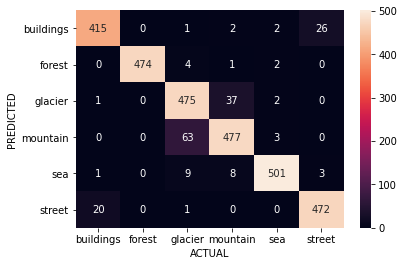

In [33]:
# Copy model to GPU and set the model to evaluation mode
model_RN_wo = model_RN_wo.to(device)
model_RN_wo.eval()

output_labels, output_preds = [], []

# Read images + labels and class names in validation dataset
data_for_inference, classnames_for_inference = dataloader_inference(folder=test_dir, input_size=RN_input_size)

for input_, label_ in data_for_inference:
  
  # Copy to GPU
  input_ = input_.to(device)
  label_ = label_.to(device)

  # No gradients required for inference
  with torch.set_grad_enabled(False):
    outputs = model_RN_wo(input_)
    _, preds = torch.max(outputs, 1)
  
  output_labels.append(label_)
  output_preds.append(preds)

actual_labels = [real_label.cpu().numpy()[0] for real_label in output_labels]
pred_labels = [pred_label.cpu().numpy()[0] for pred_label in output_preds]

# Compare prediction with actual labels
print_classreport_confmatrix(actual_labels, pred_labels, classnames_for_inference)

- The trained DenseNet-121 model is most accurate at identifying forest and sea images (Recall > 98%).
- The model is less accurate at distinguishing between streets (Recall = 94%) and buildings (Recall = 95%) as street images may contain buildings and vice-versa.
- 63 glacier images are misclassified as mountains and 37 mountain images misclassified as glaciers. This suggests glacier and mountain landscapes look much alike.

# **Conclusion**

DenseNet-121 neural network architecture and more generally pretrained neural networks have shown >90% accuracy in this image classification task. Finetuning all model layers is clearly an option to consider when dealing with a big enough training dataset (14033 images in this excercise), as the model can learn from data that is specific to the use case and achieve better performance.

**DenseNet-121 with finetuning achieves an overall classification accuracy of 94.17% while the model built from scratch is only 82.4% accurate.**

Keras provides a relatively simple and fast implementation of neural network procedures while PyTorch requires low-level data and model manipulation.

Further improvement of best model can be attempted by :
- Increasing the number of epochs
- Adjusting the learning rate


Useful material : PyTorch & keras official documentation